In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.types import VARCHAR, Float, Integer,TIMESTAMP,JSON,Date
from geoalchemy2 import Geometry, WKTElement
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift

In [2]:
server_ip='140.137.37.194'
engine = create_engine('postgresql://postgres:Co43270131@%s:5432/hyxen' %(server_ip), use_batch_mode=True, pool_size=10, max_overflow=20)
_sql='''with Hexagonal as (
SELECT COUNT(distinct device_id) AS device_id,h.hid as hid,json_object_agg(distinct ts,u.geom order by ts)as time_loc,
json_agg(distinct u.geom)loc
FROM chi."Taipei_Hexagonal_poi" h,chi.test_device_locations u
WHERE ST_Contains(h.geometry,  u.geom)
GROUP BY hid ,h.geometry)
select h.*,t.geometry,t.poi_count,t."Education", t."Transportation", t."Financial", t."Aerialway", t."Nothing", t."Food",
 t."Hospital", t.other, t."Fun"
from chi."Taipei_Hexagonal_poi" t
left join Hexagonal h
on t.hid=h.hid where device_id is not null'''

sql='''select distinct u.*
FROM chi."Taipei_Hexagonal_poi" h,chi.test_device_locations u
WHERE ST_Contains(h.geometry,  u.geom)
'''

In [3]:
gdf= gpd.GeoDataFrame.from_postgis(sql, engine, geom_col='geom' )
gdf

,lat,lon,ts,device_id,geom
0,24.968716,121.585601,2020-09-02 14:24:00,+3L1qlrgC5YOqlWmFhv4Fl2zw65sJoL1DkNlYnK2hnFBwE...,POINT (121.58560 24.96872)
1,24.968719,121.591508,2020-09-03 17:05:00,Q/7T+afsMWsfrSyyjIVW4rCOFzv7RTCR3+QZHDjmNGM1Sh...,POINT (121.59151 24.96872)
2,24.968935,121.588418,2020-09-03 18:28:00,/I3t+lHgfaM/mEJYkWo+GZcc2WIDaqL1JjxmZK5NuH/BSq...,POINT (121.58842 24.96893)
3,24.970379,121.584069,2020-09-03 17:22:00,Q/7T+afsMWsfrSyyjIVW4rCOFzv7RTCR3+QZHDjmNGM1Sh...,POINT (121.58407 24.97038)
4,24.972973,121.563533,2020-09-04 14:06:00,92p1w8boVNLIWtsgymiAL1WzTMeoGuZdpWjDucERDBXyaG...,POINT (121.56353 24.97297)
...,...,...,...,...,...
2209,25.142583,121.489249,2020-09-03 19:06:00,9TuOPn7wEycInIss6Xeuh26reqijCGRfdC61OWoD/ZxPxl...,POINT (121.48925 25.14258)
2210,25.149314,121.548585,2020-09-03 18:22:00,sJNarEE7VY1YN4bIQeF3nwZu68cXd7u8FfhzmqF/P6xEIh...,POINT (121.54858 25.14931)
2211,25.152676,121.562813,2020-09-03 18:43:00,+jS0S3OMDDgwC/0zo78IQkGf+YsEF6x3EtYS1bp158aBb2...,POINT (121.56281 25.15268)
2212,25.152986,121.545385,2020-09-01 14:18:00,9TuOPn7wEycInIss6Xeuh26reqijCGRfdC61OWoD/ZxPxl...,POINT (121.54539 25.15299)


# 分時間(平日假日)

In [5]:
gdf["ts"] = pd.to_datetime(gdf["ts"],format="%Y%m&d%H%M%S")

In [6]:
gdf["week"]=gdf["ts"].dt.dayofweek

In [7]:
#假日=H,平日=W
week=[]
for i in gdf['week']:
    if i==5:
        week.append('H')
    elif i==6:
        week.append('H')
    else:
        week.append('W')
gdf['w']=week
md=gdf["ts"].dt.strftime('%Y-%m-%d')
hm=gdf["ts"].dt.strftime('%H:%M:%S')
gdf['md']=md
gdf['hm']=hm

In [8]:
#平日
workday=gdf[gdf['w']=='W']
workday=workday.reset_index(drop=True)
workday

,lat,lon,ts,device_id,geom,week,w,md,hm
0,24.968716,121.585601,2020-09-02 14:24:00,+3L1qlrgC5YOqlWmFhv4Fl2zw65sJoL1DkNlYnK2hnFBwE...,POINT (121.58560 24.96872),2,W,2020-09-02,14:24:00
1,24.968719,121.591508,2020-09-03 17:05:00,Q/7T+afsMWsfrSyyjIVW4rCOFzv7RTCR3+QZHDjmNGM1Sh...,POINT (121.59151 24.96872),3,W,2020-09-03,17:05:00
2,24.968935,121.588418,2020-09-03 18:28:00,/I3t+lHgfaM/mEJYkWo+GZcc2WIDaqL1JjxmZK5NuH/BSq...,POINT (121.58842 24.96893),3,W,2020-09-03,18:28:00
3,24.970379,121.584069,2020-09-03 17:22:00,Q/7T+afsMWsfrSyyjIVW4rCOFzv7RTCR3+QZHDjmNGM1Sh...,POINT (121.58407 24.97038),3,W,2020-09-03,17:22:00
4,24.972973,121.563533,2020-09-04 14:06:00,92p1w8boVNLIWtsgymiAL1WzTMeoGuZdpWjDucERDBXyaG...,POINT (121.56353 24.97297),4,W,2020-09-04,14:06:00
...,...,...,...,...,...,...,...,...,...
2162,25.142583,121.489249,2020-09-03 19:06:00,9TuOPn7wEycInIss6Xeuh26reqijCGRfdC61OWoD/ZxPxl...,POINT (121.48925 25.14258),3,W,2020-09-03,19:06:00
2163,25.149314,121.548585,2020-09-03 18:22:00,sJNarEE7VY1YN4bIQeF3nwZu68cXd7u8FfhzmqF/P6xEIh...,POINT (121.54858 25.14931),3,W,2020-09-03,18:22:00
2164,25.152676,121.562813,2020-09-03 18:43:00,+jS0S3OMDDgwC/0zo78IQkGf+YsEF6x3EtYS1bp158aBb2...,POINT (121.56281 25.15268),3,W,2020-09-03,18:43:00
2165,25.152986,121.545385,2020-09-01 14:18:00,9TuOPn7wEycInIss6Xeuh26reqijCGRfdC61OWoD/ZxPxl...,POINT (121.54539 25.15299),1,W,2020-09-01,14:18:00


In [14]:
#假日
holiday=gdf[gdf['w']=='H']
holiday=holiday.reset_index(drop=True)
holiday

,lat,lon,ts,device_id,geom,week,w,md,hm
0,24.977535,121.551420,2020-09-13 12:19:00,0HTV54yMxL4vhYzHtt/3LEunCd7M6csAosHDOcsX1bBePY...,POINT (121.55142 24.97753),6,H,2020-09-13,12:19:00
1,25.006269,121.493995,2020-09-05 19:00:00,0SPBwymYa9cDkkb+fG2nHUuKvANjlGUacwEgorBBk5Spi2...,POINT (121.49400 25.00627),5,H,2020-09-05,19:00:00
2,25.009009,121.539529,2020-09-12 21:33:00,0Db3OVcGMkvHjBCjgan1VdHSRdOBlFsOrXoEq/jk7zldv8...,POINT (121.53953 25.00901),5,H,2020-09-12,21:33:00
3,25.009009,121.539529,2020-09-12 23:31:00,0Db3OVcGMkvHjBCjgan1VdHSRdOBlFsOrXoEq/jk7zldv8...,POINT (121.53953 25.00901),5,H,2020-09-12,23:31:00
4,25.009009,121.539529,2020-09-13 17:50:00,0Db3OVcGMkvHjBCjgan1VdHSRdOBlFsOrXoEq/jk7zldv8...,POINT (121.53953 25.00901),6,H,2020-09-13,17:50:00
5,25.009009,121.539529,2020-09-13 21:59:00,0Db3OVcGMkvHjBCjgan1VdHSRdOBlFsOrXoEq/jk7zldv8...,POINT (121.53953 25.00901),6,H,2020-09-13,21:59:00
6,25.009009,121.539529,2020-09-26 11:16:00,0Db3OVcGMkvHjBCjgan1VdHSRdOBlFsOrXoEq/jk7zldv8...,POINT (121.53953 25.00901),5,H,2020-09-26,11:16:00
7,25.009009,121.539529,2020-09-26 23:14:00,0Db3OVcGMkvHjBCjgan1VdHSRdOBlFsOrXoEq/jk7zldv8...,POINT (121.53953 25.00901),5,H,2020-09-26,23:14:00
8,25.009009,121.539529,2020-09-27 18:58:00,0Db3OVcGMkvHjBCjgan1VdHSRdOBlFsOrXoEq/jk7zldv8...,POINT (121.53953 25.00901),6,H,2020-09-27,18:58:00
9,25.009009,121.539529,2020-09-27 21:58:00,0Db3OVcGMkvHjBCjgan1VdHSRdOBlFsOrXoEq/jk7zldv8...,POINT (121.53953 25.00901),6,H,2020-09-27,21:58:00


In [9]:
workday0900_1700=workday[workday['hm'].between("09:00:00","17:00:00")]
workday0900_1700=workday0900_1700.reset_index(drop=True)
workday0900_1700

,lat,lon,ts,device_id,geom,week,w,md,hm
0,24.968716,121.585601,2020-09-02 14:24:00,+3L1qlrgC5YOqlWmFhv4Fl2zw65sJoL1DkNlYnK2hnFBwE...,POINT (121.58560 24.96872),2,W,2020-09-02,14:24:00
1,24.972973,121.563533,2020-09-04 14:06:00,92p1w8boVNLIWtsgymiAL1WzTMeoGuZdpWjDucERDBXyaG...,POINT (121.56353 24.97297),4,W,2020-09-04,14:06:00
2,24.972973,121.563533,2020-09-04 14:32:00,CxtRY0LaKC1WE/ibDLP4/g0ry6g2FMUJwhyog8NqngXZ/3...,POINT (121.56353 24.97297),4,W,2020-09-04,14:32:00
3,24.972973,121.583409,2020-09-02 14:35:00,DVyTwYWIMWJgYV5i8bUcqJAhdib7Ebkw8dWkCmJqnCp+Hl...,POINT (121.58341 24.97297),2,W,2020-09-02,14:35:00
4,24.974747,121.552582,2020-09-02 10:32:00,WmuaTjqUuWbAzQix13z+3V7MzGyG8FI6z4FjVgpGQLRM/q...,POINT (121.55258 24.97475),2,W,2020-09-02,10:32:00
...,...,...,...,...,...,...,...,...,...
1275,25.137700,121.503501,2020-09-01 11:38:00,vDzP8A2HdfARWvlKeK/2Rf1UPAojq0R+MOle0r2i1jdtAk...,POINT (121.50350 25.13770),1,W,2020-09-01,11:38:00
1276,25.138875,121.506845,2020-09-02 14:32:00,0qk6+uyZroX7K6qwp7FcROKwNOCs15y/FLSMtoEAi63NUT...,POINT (121.50684 25.13888),2,W,2020-09-02,14:32:00
1277,25.139505,121.530481,2020-10-12 15:37:00,0TvcjU+t8iCkriq4zRmIpux19bYezzbMSIHKnd+e7sAcXR...,POINT (121.53048 25.13951),0,W,2020-10-12,15:37:00
1278,25.152986,121.545385,2020-09-01 14:18:00,9TuOPn7wEycInIss6Xeuh26reqijCGRfdC61OWoD/ZxPxl...,POINT (121.54539 25.15299),1,W,2020-09-01,14:18:00


In [10]:
workday2200_0600_1=workday[workday['hm'].between("00:00:00","06:00:00")]
workday2200_0600_2=workday[workday['hm'].between("22:00:00","24:00:00")]
workday2200_0600=pd.concat([workday2200_0600_1,workday2200_0600_2])
workday2200_0600=workday2200_0600.reset_index(drop=True)
workday2200_0600

,lat,lon,ts,device_id,geom,week,w,md,hm
0,24.990618,121.540447,2020-09-03 00:15:00,tVYwhF5yrAk64NfKEq9NNC3eSJk3GfXlcjZJbPOL0rsRcc...,POINT (121.54045 24.99062),3,W,2020-09-03,00:15:00
1,24.992308,121.539544,2020-09-03 00:15:00,tVYwhF5yrAk64NfKEq9NNC3eSJk3GfXlcjZJbPOL0rsRcc...,POINT (121.53954 24.99231),3,W,2020-09-03,00:15:00
2,24.999061,121.544210,2020-09-04 02:22:00,OH4rfb6paDjtdWj0Ch4HwT4PUEIwtqbgjzJ+vaBq1P5uP6...,POINT (121.54421 24.99906),4,W,2020-09-04,02:22:00
3,25.019638,121.545145,2020-09-03 05:01:00,Ah662fADAcxT1CWtC1I8H8dxEPXjm+YZ8o72PrI0w3+nu9...,POINT (121.54515 25.01964),3,W,2020-09-03,05:01:00
4,25.020889,121.540995,2020-09-03 05:01:00,Ah662fADAcxT1CWtC1I8H8dxEPXjm+YZ8o72PrI0w3+nu9...,POINT (121.54099 25.02089),3,W,2020-09-03,05:01:00
...,...,...,...,...,...,...,...,...,...
121,25.079574,121.596895,2020-09-02 23:56:00,YDktRfDfOsmM+nXBjsYkY5OIGgVDoXjcykbfm96nbl278R...,POINT (121.59690 25.07957),2,W,2020-09-02,23:56:00
122,25.079742,121.597037,2020-09-02 23:56:00,YDktRfDfOsmM+nXBjsYkY5OIGgVDoXjcykbfm96nbl278R...,POINT (121.59704 25.07974),2,W,2020-09-02,23:56:00
123,25.080235,121.549411,2020-09-01 22:35:00,f7LY6OoS6biRM6lJNW6sDC0ew468K6i9MOWyupw3ELfdNT...,POINT (121.54941 25.08023),1,W,2020-09-01,22:35:00
124,25.082129,121.570358,2020-09-02 22:46:00,q2ad7aHUF1Yg5YdlQH4HcGo8OKaX8My3ivKitLYTvl4b3R...,POINT (121.57036 25.08213),2,W,2020-09-02,22:46:00


In [15]:
gdf

,lat,lon,ts,device_id,geom,week,w,md,hm
0,24.968716,121.585601,2020-09-02 14:24:00,+3L1qlrgC5YOqlWmFhv4Fl2zw65sJoL1DkNlYnK2hnFBwE...,POINT (121.58560 24.96872),2,W,2020-09-02,14:24:00
1,24.968719,121.591508,2020-09-03 17:05:00,Q/7T+afsMWsfrSyyjIVW4rCOFzv7RTCR3+QZHDjmNGM1Sh...,POINT (121.59151 24.96872),3,W,2020-09-03,17:05:00
2,24.968935,121.588418,2020-09-03 18:28:00,/I3t+lHgfaM/mEJYkWo+GZcc2WIDaqL1JjxmZK5NuH/BSq...,POINT (121.58842 24.96893),3,W,2020-09-03,18:28:00
3,24.970379,121.584069,2020-09-03 17:22:00,Q/7T+afsMWsfrSyyjIVW4rCOFzv7RTCR3+QZHDjmNGM1Sh...,POINT (121.58407 24.97038),3,W,2020-09-03,17:22:00
4,24.972973,121.563533,2020-09-04 14:06:00,92p1w8boVNLIWtsgymiAL1WzTMeoGuZdpWjDucERDBXyaG...,POINT (121.56353 24.97297),4,W,2020-09-04,14:06:00
...,...,...,...,...,...,...,...,...,...
2209,25.142583,121.489249,2020-09-03 19:06:00,9TuOPn7wEycInIss6Xeuh26reqijCGRfdC61OWoD/ZxPxl...,POINT (121.48925 25.14258),3,W,2020-09-03,19:06:00
2210,25.149314,121.548585,2020-09-03 18:22:00,sJNarEE7VY1YN4bIQeF3nwZu68cXd7u8FfhzmqF/P6xEIh...,POINT (121.54858 25.14931),3,W,2020-09-03,18:22:00
2211,25.152676,121.562813,2020-09-03 18:43:00,+jS0S3OMDDgwC/0zo78IQkGf+YsEF6x3EtYS1bp158aBb2...,POINT (121.56281 25.15268),3,W,2020-09-03,18:43:00
2212,25.152986,121.545385,2020-09-01 14:18:00,9TuOPn7wEycInIss6Xeuh26reqijCGRfdC61OWoD/ZxPxl...,POINT (121.54539 25.15299),1,W,2020-09-01,14:18:00


In [16]:
from geoalchemy2 import Geometry,WKTElement
server_ip='140.137.37.194'
engine = create_engine('postgresql://postgres:Co43270131@%s:5432/hyxen' %(server_ip), use_batch_mode=True)
gdf['geometry'] = gdf['geom'].apply(lambda x: WKTElement(x.wkt, srid=4326))
gdf.drop('geom',1,inplace=True)

In [18]:
gdf.to_sql('test_taipeiuser_time',engine, if_exists='replace',index=False,schema='chi',dtype={'geometry': Geometry('POINT ', srid = 4326)})

<AxesSubplot:>

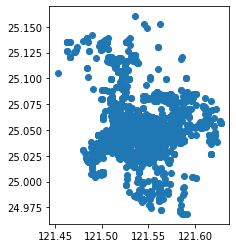

In [4]:
gdf.plot()


In [5]:
#dx, dy = make_blobs(n_samples=500, n_features=2, centers=clusters, random_state=42)
dx = gdf[["lon", "lat"]].to_numpy()
KMeans(dx)

In [13]:
def KMeans_def(dx):
    colors = ['red', 'orange', 'yellow', 'green', 'cyan',
          'blue', 'purple', 'brown', 'grey', 'black']
    # 產生的資料組數 (10)
    clusters = 10
    # K 值的範圍 (2~10)
    k_range = range(2, clusters + 1)
    distortions = []
    scores = []
    # 記錄每種 K 值建出的 KMeans 模型的成效
    for i in k_range:
        kmeans = KMeans(n_clusters=i).fit(dx)
        distortions.append(kmeans.inertia_) # 誤差平方和 (SSE)
        scores.append(silhouette_score(dx, kmeans.predict(dx))) # 側影係數
    # 找出最大的側影係數來決定 K 值
    selected_K = scores.index(max(scores)) + 2
    # 重新建立 KMeans 模型並預測目標值
    kmeans = KMeans(n_clusters=selected_K).fit(dx)
    new_dy = kmeans.predict(dx)
    # 新分組的資料中心點
    centers = kmeans.cluster_centers_
    plt.rcParams['font.size'] = 12
    plt.figure(figsize=(12, 12))
    # 原始資料分組
    plt.subplot(221)
    plt.title(f'Original data ({clusters} groups)')
    plt.scatter(dx.T[0], dx.T[1], c='b', cmap=plt.cm.Set1)
    # 新資料分組
    plt.subplot(222)
    plt.title(f'KMeans={selected_K} groups')
    plt.scatter(dx.T[0], dx.T[1], c=new_dy, cmap=plt.cm.Set3)
    plt.scatter(centers.T[0], centers.T[1], marker='^', color='orange')
    for i in range(centers.shape[0]): # 標上各分組中心點
        plt.text(centers.T[0][i], centers.T[1][i], str(i + 1),
                fontdict={'color': 'red', 'weight': 'bold', 'size': 24})
    # 繪製誤差平方和圖 (手肘法)
    plt.subplot(223)
    plt.title('SSE (elbow method)')
    plt.plot(k_range, distortions)
    plt.plot(selected_K, distortions[selected_K - 2], 'go') # 最佳解
    # 繪製側影係數圖
    plt.subplot(224)
    plt.title('Silhouette score')
    plt.plot(k_range, scores)
    plt.plot(selected_K, scores[selected_K - 2], 'go') # 最佳解
    plt.tight_layout()
    plt.show()

<AxesSubplot:>

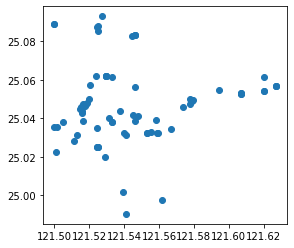

In [11]:
test=gdf[gdf['device_id']=='IJd95z5MbduN9R6/HBioIfscE1iuj+DzP2Cc96EHAt7dMLqKTC9sMjaU9w12GccQ']
test.plot()

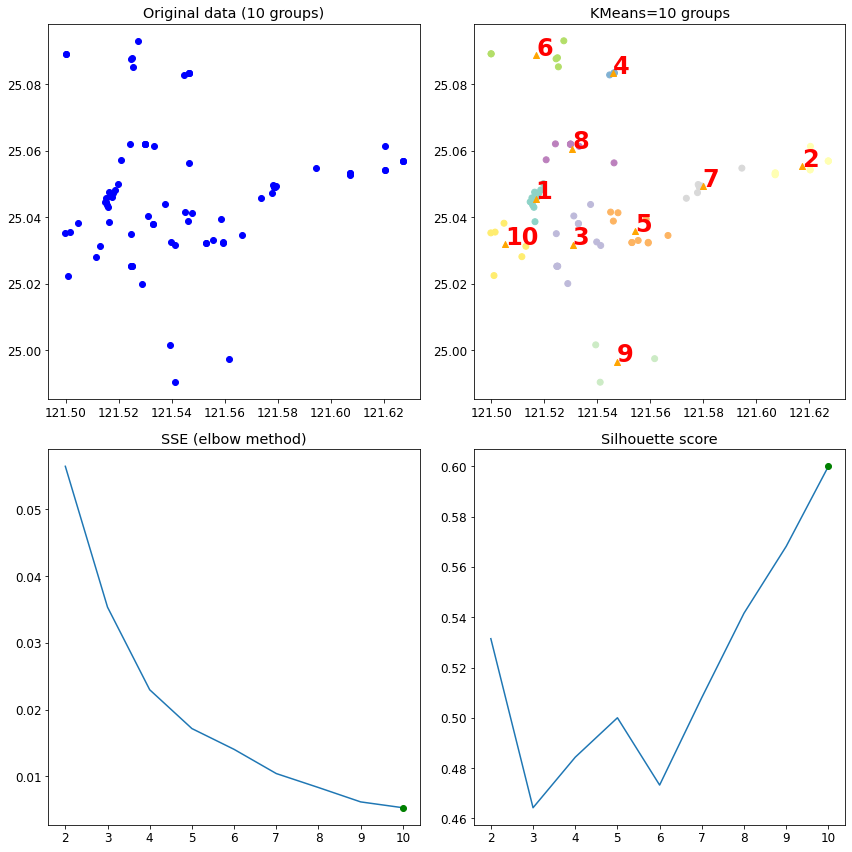

In [15]:
dx_test = test[["lon", "lat"]].to_numpy()
KMeans_def(dx_test)